In [1]:
import glob
import os
import platform
import random
import shutil
from collections import Counter
from multiprocessing.dummy import Pool
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm

In [2]:
if platform.system() == "Windows":
    # PC
    folder = r"Z:\Screen_Time_Measure_Development\SNAP_IT\YOLO_Training\Labelled_Data"
    main_folder = r"Z:\Screen_Time_Measure_Development\SNAP_IT"
    copy_to_folder = r"Z:\Screen_Time_Measure_Development\SNAP_IT\YOLO_Training\To Label"
elif platform.system() == "Darwin":
    # Mac
    folder = r"/Volumes/M&B/Screen_Time_Measure_Development/SNAP_IT/YOLO_Training/Labelled_Data"
    main_folder = r"/Volumes/M&B/Screen_Time_Measure_Development/SNAP_IT"
    copy_to_folder = r"/Volumes/M&B/Screen_Time_Measure_Development/SNAP_I/YOLO_Training/To Label"

folders = ["1005", "1104","1106","1113","1121","1123","1128","1160","1174","1447","1502","1637"]

In [3]:
def read_txt(file):
    with open(file, "r") as f:
        return Counter(list(map(int, f.read().split()[::5])))


def get_images(subfolder):
    return glob.glob(main_folder + "//" + subfolder + "//*//*.jpg")


def get_basename(filepath):
    return os.path.basename(filepath).split(".")[0]


def get_new_images():
    part_id = random.choice(images["participant"].unique())
    top_rand = random.randrange(
        0,
        images.loc[(images["participant"] == part_id) & (images["labelled"] == False)]
        .reset_index(drop=True)
        .index.max()
        - 50,
    )
    next_images = list(
        images.loc[(images["participant"] == part_id) & (images["labelled"] == False)]
        .reset_index(drop=True)
        .loc[top_rand:top_rand+49, "filepath"]
    )
    for next_image in tqdm.tqdm(next_images):
        shutil.copyfile(
            next_image, copy_to_folder + "\\" + os.path.basename(next_image)
        )

In [4]:
%%time
pool = Pool()
imgs = pool.map(get_images, folders)
pool.close()
pool.join()

imgs = [item for sublist in imgs for item in sublist]

Wall time: 29.7 s


In [5]:
%%time
files = glob.glob(folder + "//*image*.txt")
with open(folder + "//classes.txt", "r") as f:
    classes = [line.strip("\n") for line in f.readlines()]

labels = pd.DataFrame(data=classes, columns=["label"])
labels = labels.reindex(columns=["label", "objects", "images"])
labels.fillna(0, inplace=True)

pool = Pool()
results = pool.map(read_txt, files)
pool.close()
pool.join()

for codes in results:
    for key in codes:
        labels.loc[key, "objects"] += codes[key]
        labels.loc[key, "images"] += 1

Wall time: 24.7 s


In [6]:
images = pd.DataFrame(imgs, columns=["filepath"])
images["basename"] = images["filepath"].apply(get_basename)
images["participant"] = images["basename"].apply(lambda x: x[:4])
images["labelled"] = images["basename"].isin(
    [get_basename(x) for x in files]
)

files: 801
images: 953.0


<AxesSubplot:xlabel='participant'>

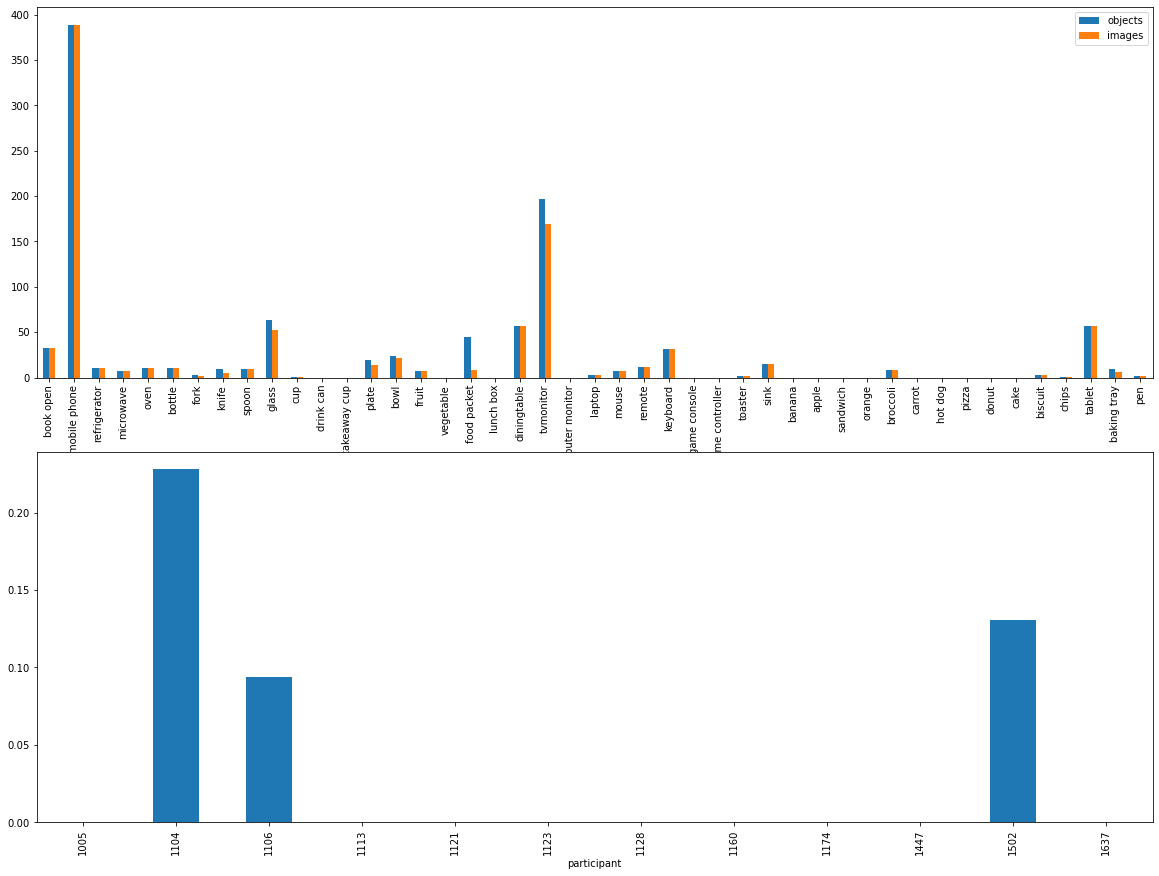

In [7]:
print(f"files: {len(files)}")
print(f"images: {labels['images'].sum()}")
fig, (ax,ax2) = plt.subplots(nrows=2, figsize=(20,15))
labels.plot(kind="bar", x="label",ax=ax)
images.groupby("participant")['labelled'].mean().plot(kind='bar',ax=ax2)

In [8]:
get_new_images()

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:34<00:00,  1.46it/s]
